In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 24.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.7 MB/s eta 0:00:00


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import XLMRobertaModel,AutoTokenizer
import optuna
from sklearn.metrics import accuracy_score
import numpy as np

In [4]:
#Data Preprocessing
df = pd.read_csv(r"/content/drive/MyDrive/MTECH PROJECT/PRACTICE/Testing/DITSA_plus.csv")

# Filter relevant columns
df = df[['tweet', 'language', 'Sentiment']]

# Convert empty values to NaN
df['tweet'].replace('', np.nan, inplace=True)

df.dropna(subset="tweet", inplace=True)
print(df.isnull().sum())

df


tweet        0
language     0
Sentiment    0
dtype: int64


,tweet,language,Sentiment
0,நாட்டை வழிநடத்தும் தகுதி ராகுலுக்கு உள்ளது சிவ...,ta,Neutral
1,congratulations to all four who bagged gold on...,en,Positive
2,ಈ ಹಣವು ಕಾಂಬೋಡಿಯಾ ಚೀನಾದಲ್ಲಿ ನಡೆಯುತ್ತಿರುವ ಪ್ರಾದೇ...,kn,Neutral
3,इसराइल के साथ हाथ मिलाने की बारी अब क्या ओमान है,hi,Neutral
4,ಕರೋನವೈರಸ್ಫೈಜಾನ್ ಹಶ್ಮಿಯಿಂದ ಫ್ರಾನ್ಸ್ ಮೊದಲ ಫ್ರೆಂಚ...,kn,Neutral
...,...,...,...
499821,आज nda की ओर से उपराष्ट्रपति पद के प्रत्याशी श...,hi,Positive
499822,पूर्व मुख्यमंत्री जी ने आज nda की ओर से उपराष्...,hi,Neutral
499823,आज nda की ओर से उपराष्ट्रपति पद के प्रत्याशी श...,hi,Positive
499824,nda क़े उपराष्ट्रपति पद के उम्मीदवार श्री जगदी...,hi,Neutral


In [5]:
# Split the dataset into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Convert sentiment labels to numerical values
label2id = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
train_df['label'] = train_df['Sentiment'].map(label2id)
test_df['label'] = test_df['Sentiment'].map(label2id)

In [6]:
class TwitterDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        tweet = self.df.iloc[idx]['tweet']
        label = self.df.iloc[idx]['label']
        
        encoding = self.tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }


In [7]:
class CustomROBERTAClassifier(nn.Module):
    def __init__(self, num_labels):
        super(CustomROBERTAClassifier, self).__init__()
        self.roberta = XLMRobertaModel.from_pretrained('xlm-roberta-large')
        self.dropout = nn.Dropout(0.3)
        self.conv1d = nn.Conv1d(self.roberta.config.hidden_size, 128, kernel_size=3, padding=1)
        self.lstm = nn.LSTM(128, 64, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(128, num_labels)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        pooled_output = pooled_output.unsqueeze(2)
        
        conv_output = self.conv1d(pooled_output)
        conv_output = conv_output.transpose(1, 2)
        
        lstm_output, _ = self.lstm(conv_output)
        lstm_output = lstm_output[:, -1, :]
        
        logits = self.fc(lstm_output)
        return logits


In [8]:
# def train(model, train_loader, criterion, optimizer, device):
#     model.train()
#     train_loss = 0.0
#     train_acc = 0.0
    
#     for batch in train_loader:
#         input_ids = batch['input_ids'].to(device)
#         attention_mask = batch['attention_mask'].to(device)
#         labels = batch['label'].to(device)
        
#         optimizer.zero_grad()
        
#         logits = model(input_ids, attention_mask)
        
#         loss = criterion(logits, labels)
#         loss.backward()
#         optimizer.step()
        
#         train_loss += loss.item() * input_ids.size(0)
#         _, predicted_labels = torch.max(logits, 1)
#         train_acc += torch.sum(predicted_labels == labels).item()
    
#     train_loss = train_loss / len(train_loader.dataset)
#     train_acc = train_acc / len(train_loader.dataset)
    
#     return train_loss, train_acc


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 10

In [ ]:
# tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-large')
# train_dataset = TwitterDataset(train_df, tokenizer, max_length=128)
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

# model = CustomROBERTAClassifier(num_labels=3)
# model.to(device)

# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.AdamW(model.parameters(), lr=2.4245311885086787e-05)

# for epoch in range(num_epochs):
#     train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    
#     print(f'Epoch {epoch + 1}/{num_epochs}')
#     print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')

# # Save the trained model
# torch.save(model.state_dict(), 'custom_roberta_classifier.pth')

In [10]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import LabelBinarizer

# Load the saved model
model = CustomROBERTAClassifier(num_labels=3)
model.load_state_dict(torch.load('/content/drive/MyDrive/MTECH PROJECT/PRACTICE/Testing/custom_roberta_classifier.pth', map_location=device))
model.to(device)

# Create test dataset and data loader
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-large')
test_dataset = TwitterDataset(test_df[0:10000], tokenizer, max_length=128)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# Evaluate the model on the test set and make predictions
criterion = nn.CrossEntropyLoss()
test_loss, test_acc = 0, 0
test_predictions, test_probabilities = [], []

model.eval()

with torch.no_grad():
    for batch in tqdm(test_loader, desc='Evaluating'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        test_loss += loss.item()

        probabilities = torch.softmax(logits, dim=1)
        _, predicted_labels = torch.max(logits, 1)

        test_acc += (predicted_labels == labels).sum().item()

        test_predictions.extend(predicted_labels.cpu().numpy())
        test_probabilities.extend(probabilities.cpu().numpy()[:, 2])  # Probability of positive class

# Calculate average loss and accuracy
test_loss /= len(test_loader.dataset)
test_acc /= len(test_loader.dataset)

# Convert predictions to numpy arrays
test_predictions = np.array(test_predictions)
test_probabilities = np.array(test_probabilities)

# Print evaluation results
print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}')




Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluating: 100%|██████████| 157/157 [03:28<00:00,  1.33s/it]

Test Loss: 0.0162 | Test Acc: 0.5433


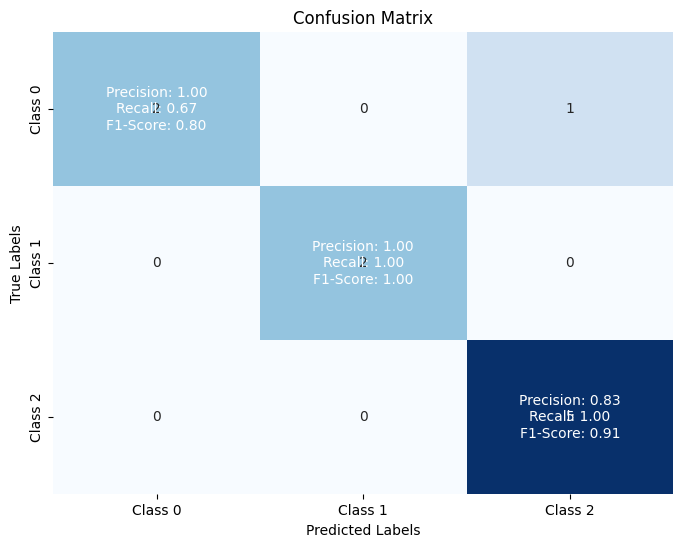

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Convert predictions and ground truth labels to numpy arrays
test_labels = np.array(test_df['label'])
test_predictions = np.array(test_predictions)

# Compute the confusion matrix
cm = confusion_matrix(test_labels, test_predictions)

# Calculate precision, recall, and F1-score
precision = np.diag(cm) / np.sum(cm, axis=0)
recall = np.diag(cm) / np.sum(cm, axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)

# Create a list of class labels
class_labels = ['Class 0', 'Class 1', 'Class 2']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Add labels to the x-axis
plt.xticks(ticks=np.arange(len(class_labels)) + 0.5, labels=class_labels)
plt.yticks(ticks=np.arange(len(class_labels)) + 0.5, labels=class_labels)

# Add precision, recall, and F1-score to the plot
for i in range(len(class_labels)):
    plt.text(i + 0.5, i + 0.5, f'Precision: {precision[i]:.2f}\nRecall: {recall[i]:.2f}\nF1-Score: {f1_score[i]:.2f}',
             ha='center', va='center', color='white')

plt.show()


In [12]:

# Predict positive tweets with probabilities
positive_tweets_indices = np.where(test_predictions == 2)[0]
positive_tweets_probabilities = test_probabilities[positive_tweets_indices]

positive_tweets = test_df.iloc[positive_tweets_indices]
positive_tweets['probability'] = positive_tweets_probabilities

print("Positive Tweets:")
positive_tweets = positive_tweets[['tweet', 'probability']]
positive_tweets


Positive Tweets:


<ipython-input-12-c276362ab477>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_tweets['probability'] = positive_tweets_probabilities


,tweet,probability
35863,covid ಸರಾಸರಿ ಕಾಲೋಚಿತ ಜ್ವರಕ್ಕಿಂತ ಹೆಚ್ಚು ಮಾರಕವಾಗ...,0.493243
433796,#सतलोक vs पृथ्वीलोक sant rampal ji maharaj काल...,0.493243
390580,this game 🧐 mitrovic again for fulham now,0.493243
227230,वित्त मंत्रालय ने lic के ipo लिए लेनदेन सलाहका...,0.493243
372865,we will lose to fulham because they have a goa...,0.493243
...,...,...
231050,we’ll see against fulham the,0.493243
204234,दिल्ली में कोरोना जांच की फर्जी रिपोर्ट बनाने ...,0.493243
142206,there's nothing better than being yourself let...,0.493243
325638,could you imagine if jake paul was fighting sw...,0.493243


In [13]:
positive_tweets_filtered = positive_tweets[positive_tweets['probability'] >= 0.98]
positive_tweets_filtered

,tweet,probability
